## About this Notebook

**Similar to FR_t01e01nb03v1, this will focus in training RESNET**

## Import libraries

In [1]:
import os
import random
# report more detail errors 
os.environ["TORCH_USE_CUDA_DSA"] = "1"

import gc
import glob
import pickle
from pathlib import Path, PureWindowsPath

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score

import cv2

import torch

from torch.utils.data import Dataset 
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim


#___
from torchview import draw_graph

#___
# # if there is error related to CUDA could be related to asynchronous 
# # to force synchronous run this, (it could result in slower operations)
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Config

In [3]:
class cfg: 
    #==================================================
    # THIS NOTEBOOK ID
    THIS_NOTEBOOK_REF = "FR_t01e01nb04v2" # # RepeatedCV ResNET

    preprocessing_pipe = 'pipe003'
    meta_csv_preprocessing_pipe = f"FR_t01e01nb02v3_metadata_pipe003.csv"

    #==================================================
    # ROOT PIPE001
    ROOT_PIPE = os.path.join('..', '..', '..',
                             'data',
                             preprocessing_pipe ,
                            )


    METADATA_PIPE = os.path.join('..', '..', '..',
                                 'data',
                                 preprocessing_pipe,
                                 meta_csv_preprocessing_pipe,
                                )
    
    #==================================================
    # TO STORE RESULTS
    ROOT_TO_SAVE_RESLT = os.path.join('..', '..', '..',
                                      "results",
                                      "exp_track"
                                     )
    os.makedirs(ROOT_TO_SAVE_RESLT, exist_ok=True)   

## Utility Functions

### custom_StratifiedKFold()

In [4]:
def custom_StratifiedKFold(d_meta, n_splits=5, 
                            cls_col="cls_id", 
                            inst_n_order_col="img_n_order", 
                            shuffle_instances=False, 
                            random_state=42,
                           ):
    
    """
    Description:
    ------------
        sklearn StratifiedKFold does not keep order. This is a custom function
            to has an option to stratify will keeping the order of the images. 
    
    Paramters:
    ----------
        n_splits: number of folds. "5: 20% each fold"
        cls_col: name of the column in metadata dataframe that indicates classes
        inst_n_order_col: name of column that indicate original order of the instances.
        shuffle_instances: True or False.
        random_state: random seed to obtain always the same instances per fold. 
        
        
    Return:
    -------
        folds: list of lists. Each inner list holds the list of img_ID that belong to the fold. 
                - Structure: [ list_of_img_ids_fold0, ..., list_of_img_ids_fold_n]
    
    
    """
    #============================================================================================
    d = d_meta.copy()
    #============================================================================================
    # Stratify Kfold per class - Custom solution to keep original order. 
    store_fold_per_class = []
    for label in d[cls_col].unique():

        if shuffle_instances: 

            # Select img class >> extract list of unique img_ID >> split list in n_split
            c1 = d[cls_col] == label
            d1 = d[c1].sample(frac=1, random_state=random_state).reset_index(drop=True)
            folds_per_class = np.array_split(d1["img_ID"].to_list(), n_splits)

            store_fold_per_class.append(folds_per_class)

        else: # False: keep img original order
            
            # Select img class >> **sort** & extract list of unique img_ID >> split list in n_split
            c1 = d[cls_col] == label
            d1 = d[c1].sort_values(by=[inst_n_order_col], ascending=True).reset_index(drop=True)
    
            #--------------
            # Rotation and then split 
            img_id_in_order = d1["img_ID"].to_list()
            n = len(img_id_in_order)
            
            rng = random.Random(random_state)
            start_idx = rng.randint(0, n - 1)
    
            rotated = img_id_in_order[start_idx:] + img_id_in_order[:start_idx]
    
            # Split keeping order
            folds_per_class = np.array_split(rotated, n_splits) # out folds_per_class = [[imgIds fold0], ..., [imgIds fold_n]]
    
            store_fold_per_class.append(folds_per_class) # out [folds_per_class 0, ..., folds_per_class m_class]

        #____________________________________________________
        # break

    #============================================================================================
    # unpack store_fold_per_class and concat fold wise each class element.
    folds = []
    for cls_fold_imgs in zip(*store_fold_per_class):
        concat_fold_imgs = np.hstack(cls_fold_imgs)
        folds.append(concat_fold_imgs)
        #____________________________________________________
        # break
    #============================================================================================
    
    return folds
    
    
    

### train_step()

In [5]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               #loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               arch_id,
               weights,
               epoch_n,
              ): 
    
    #-------------------------------------------------------
    train_loss = 0
    probs_lst = []
    preds_lst = []
    img_id_lst = []
    y_true_lst = []
    loss_lst = []
    for batch, (arr_img, y_true, img_id) in enumerate(dataloader):
        
        #___________________________________________________________
        X, y = arr_img.to(device), y_true.to(device)
        
        w = torch.tensor(list(weights.values()), dtype=torch.float32).to(device)
        
        #___________________________________________________________
        raw_logits = model(X.float())
        
        
        loss_fn = nn.CrossEntropyLoss(weight=w, reduction='none')
        losses = loss_fn(raw_logits, y)
        total_loss = losses.mean()
        train_loss += total_loss.item()
        
        #___________________________________________________________
        optimizer.zero_grad()
    
        total_loss.backward()
        
        optimizer.step()
        
        #__________________________________________________________
        # Store training values
        probs = torch.softmax(raw_logits, dim=1)
        preds = torch.argmax(probs, dim=1) 
        probs_lst.append(probs.cpu().detach().numpy().squeeze())
        preds_lst += list(preds.cpu().detach().numpy().squeeze())
        img_id_lst += list(img_id)
        y_true_lst += y_true.tolist()
        loss_lst += list(losses.cpu().detach().numpy().squeeze())
        
        #__________________________________________________________
        # break
    #--------------------------------------------------------------
    # Extract this training epoch results. 

    trn_loss = train_loss / (batch+1) #len(dataloader)
    
    probs_per_cls = np.vstack(probs_lst)
    d_reslts = pd.DataFrame(probs_per_cls, columns=['0','1','2',])
    d_reslts["y_pred"] = preds_lst
    d_reslts["y_true"] = y_true_lst
    d_reslts['weight'] = d_reslts['y_true'].map(weights) # Weight per class| subject level info not avaialble.
    d_reslts["loss"] = loss_lst
    d_reslts["epoch_n"] = epoch_n
    d_reslts["img_ID"] = img_id_lst
    d_reslts["arch_ID"] = arch_id
    d_reslts["trn_tst"] = "trn"

    acc_trn = accuracy_score(d_reslts["y_true"], d_reslts["y_pred"], sample_weight=d_reslts["weight"])

    #---------------------------------------------
    return trn_loss, acc_trn, d_reslts
    

### test_step()

In [6]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              arch_id="vanilla2DCNN_v1", 
              epoch_n=0):
    
    tst_loss = 0
    probs_lst = []
    preds_lst = []
    img_id_lst = []
    y_true_lst = []
    loss_lst = []

    #________________________________________________________________
    with torch.inference_mode():
    
        # Loop through DataLoader batches
        for batch, (arr_img, y_true, img_id) in enumerate(dataloader):
            #___________________________________________________________
            X, y = arr_img.to(device), y_true.to(device)
            #___________________________________________________________
            raw_logits = model(X.float())
            
            
            loss_fn = nn.CrossEntropyLoss(weight=None, reduction='none')
            losses = loss_fn(raw_logits, y)
            total_loss = losses.mean()
            tst_loss += total_loss.item()
        
            #__________________________________________________________
            # Store training values
            probs = torch.softmax(raw_logits, dim=1)
            preds = torch.argmax(probs, dim=1) 
            probs_lst.append(probs.cpu().detach().numpy().squeeze())
            preds_lst += list(preds.cpu().detach().numpy().squeeze())
            img_id_lst += list(img_id)
            y_true_lst += y_true.tolist()
            loss_lst += list(losses.cpu().detach().numpy().squeeze())
        
            #__________________________________________________________
        
            # break
    #--------------------------------------------------------------
    # Extract this training epoch results. 
    
    tst_loss = tst_loss / (batch+1) #len(dataloader)
    
    probs_per_cls = np.vstack(probs_lst)
    d_reslts = pd.DataFrame(probs_per_cls, columns=['0','1','2',])
    d_reslts["y_pred"] = preds_lst
    d_reslts["y_true"] = y_true_lst
    d_reslts['weight'] = d_reslts['y_true'].map(weights) # Weight per class| subject level info not avaialble.
    d_reslts["loss"] = loss_lst
    d_reslts["epoch_n"] = epoch_n
    d_reslts["img_ID"] = img_id_lst
    d_reslts["arch_ID"] = arch_id
    d_reslts["trn_tst"] = "tst"
    
    acc_tst = accuracy_score(d_reslts["y_true"], d_reslts["y_pred"], sample_weight=d_reslts["weight"])

    #----------------------------------------------------------------
    return tst_loss, acc_tst, d_reslts

### train()

In [7]:
def train(model,
          trn_loader,
          tst_loader,
          optimizer,
          weights,
          epochs,
          arch_id,
          foldID,
          track_train_id,
          to_save_root=cfg.ROOT_TO_SAVE_RESLT,
          verbose_epo_steps=1,
          save_model=True,
         ): 



    #____________________________________________________________________
    prcsn_trn_lst = []
    f1score_trn_lst = []
    rec_trn_lst = []
    ba_trn_lst = []
    acc_trn_lst = []
    loss_trn_lst = []
    
    prcsn_tst_lst = []
    f1score_tst_lst = []
    rec_tst_lst = []
    ba_tst_lst = []
    acc_tst_lst = []
    loss_tst_lst = []
    
    lr_lst = []
    epoch_ = -1
    
    #_____________________________________________________________________
    for epoch in range(epochs): 
    
        trn_loss, trn_acc, trn_rslts = train_step(model=model,
                                                  dataloader=trn_loader,
                                                  optimizer=optimizer,
                                                  weights=weights,
                                                  arch_id=arch_id,
                                                  epoch_n=epoch
                                                 )
        trn_rslts["train_trackID"] = track_train_id
        
        tst_loss, tst_acc, tst_rslts = test_step(model=model,
                                                 dataloader=tst_loader,
                                                 arch_id=arch_id,
                                                 epoch_n=epoch)
        tst_rslts["train_trackID"] = track_train_id
        
        #-----------------------------------------------------------------
        #_____________________________________________________________
        # Train metrics 
        prcsn_trn = precision_score(trn_rslts['y_true'], trn_rslts['y_pred'], average='macro', zero_division=0.0)
        f1score_trn = f1_score(trn_rslts['y_true'], trn_rslts['y_pred'], average='macro', zero_division=0.0)
        rec_trn = recall_score(trn_rslts['y_true'], trn_rslts['y_pred'], average='macro', zero_division=0.0)
        ba_trn = balanced_accuracy_score(trn_rslts['y_true'], trn_rslts['y_pred'], adjusted=True)
        acc_trn = accuracy_score(trn_rslts['y_true'], trn_rslts['y_pred'])
        loss_trn = trn_rslts['loss'].mean()
    
        #_____________________________________________________________
        # Test metrics 
        prcsn_tst = precision_score(tst_rslts['y_true'], tst_rslts['y_pred'], average='macro', zero_division=0.0)
        f1score_tst = f1_score(tst_rslts['y_true'], tst_rslts['y_pred'], average='macro', zero_division=0.0)
        rec_tst = recall_score(tst_rslts['y_true'], tst_rslts['y_pred'], average='macro', zero_division=0.0)
        ba_tst = balanced_accuracy_score(tst_rslts['y_true'], tst_rslts['y_pred'], adjusted=True)
        acc_tst = accuracy_score(tst_rslts['y_true'], tst_rslts['y_pred'])
        loss_tst = tst_rslts['loss'].mean()
    
    
        #_____________________________________________________________
        # Storage
        prcsn_trn_lst.append(prcsn_trn)
        f1score_trn_lst.append(f1score_trn)
        rec_trn_lst.append(rec_trn)
        ba_trn_lst.append(ba_trn)
        acc_trn_lst.append(acc_trn)
        loss_trn_lst.append(loss_trn)
    
        prcsn_tst_lst.append(prcsn_tst)
        f1score_tst_lst.append(f1score_tst)
        rec_tst_lst.append(rec_tst)
        ba_tst_lst.append(ba_tst)
        acc_tst_lst.append(acc_tst)
        loss_tst_lst.append(loss_tst)
    
        lr_lst.append(optimizer.param_groups[0]['lr'])
    
        #_____________________________________________________________
        if (epoch%verbose_epo_steps == 0) or (epoch==epochs-1): 
    
            print(
                f"Epo: {epoch} | "
                f"tr_loss: {loss_trn:.4f} | "
                f"tr_acc: {acc_trn:.4f} | "
                f"tst_loss: {loss_tst:.4f} | "
                f"tst_acc: {acc_tst:.4f} |"
                f"tst_ba: {ba_tst:.4f} |"
        
                f"tst_f1: {f1score_tst:.4f} |"
                f"tst_pr: {prcsn_tst:.4f} |"
                f"tst_rc: {rec_tst:.4f} |"
                f"lr: {optimizer.param_groups[0]['lr']:.6f} |"
                )
        
        #_____________________________________________________________
        # After each loop, update performance tracking in case system falls
        perf_dct = {'prcsn_trn':prcsn_trn_lst,
                    'f1score_trn':f1score_trn_lst,
                    'rec_trn':rec_trn_lst,
                    'ba_trn':ba_trn_lst,
                    'acc_trn':acc_trn_lst,
                    'loss_trn':loss_trn_lst,
                    
                    'prcsn_tst':prcsn_tst_lst,
                    'f1score_tst':f1score_tst_lst,
                    'rec_tst':rec_tst_lst,
                    'ba_tst':ba_tst_lst,
                    'acc_tst':acc_tst_lst,
                    'loss_tst':loss_tst_lst,
                    
                    'lr': lr_lst,
                    'track_train_id':track_train_id,
                    'fold_id':foldID, 
                    'arch_id':arch_id,
                   }
    
        #-----
        # Creating folders to store performace per epoch and SAVE
        root_perfom_across_epo = os.path.join(to_save_root,
                                              track_train_id,
                                              'perform_acrss_epo', #<<<<<<<<
                                              foldID)
        os.makedirs(root_perfom_across_epo, exist_ok=True)
        pickle_fname = f"performance_across_Epochs.pkl"
        fpath = os.path.join(root_perfom_across_epo, pickle_fname)
        with open(fpath, 'wb') as fp:
            pickle.dump(perf_dct, fp)
    
        #_____________________________________________________________
        # Saving predictions of last epochs. 
        m_path = os.path.join(to_save_root, track_train_id, "predictions", foldID)
        os.makedirs(m_path, exist_ok=True)
    
        fpath = os.path.join(m_path, "train_result.csv")
        trn_rslts.to_csv(fpath, index=False)
    
        fpath = os.path.join(m_path, "test_result.csv")
        tst_rslts.to_csv(fpath, index=False)

        #_____________________________________________________________
        # Saving model weights of last training epoch.
        m_path = os.path.join(to_save_root, track_train_id, "models", foldID)
        os.makedirs(m_path, exist_ok=True)

        if save_model:
            model_path = os.path.join(m_path, f"{cfg.THIS_NOTEBOOK_REF}_{foldID}_epo_{epoch}_{track_train_id}_.pth")
            if epoch > epoch_:
                model_path_previous = os.path.join(m_path, f"{cfg.THIS_NOTEBOOK_REF}_{foldID}_epo_{epoch_}_{track_train_id}_.pth")
                if os.path.isfile(model_path_previous):
                    os.remove(model_path_previous) 
    
            torch.save(model.state_dict(), model_path)

        #_____________________________________________________________
        epoch_ = epoch
        #_____________________________________________________________
        # break
    #_____________________________________________________________


    return trn_rslts, tst_rslts

## Read Meta Pipe 

In [8]:
fpath = cfg.METADATA_PIPE
fpath

'../../../data/pipe003/FR_t01e01nb02v3_metadata_pipe003.csv'

In [9]:
pipe_meta = pd.read_csv(fpath)
pipe_meta.rename(columns={f'path_img_{cfg.preprocessing_pipe}':'path_img_pipe'}, inplace=True)
pipe_meta.info()
pipe_meta.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path_original_img   1097 non-null   object
 1   img_ID              1097 non-null   object
 2   path_img_pipe       1097 non-null   object
 3   img_shape_original  1097 non-null   object
 4   img_shape_pipe003   1097 non-null   object
 5   img_n_order         1097 non-null   int64 
 6   cls_name            1097 non-null   object
 7   cls_id              1097 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 68.7+ KB


,path_original_img,img_ID,path_img_pipe,img_shape_original,img_shape_pipe003,img_n_order,cls_name,cls_id
0,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order1,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,1,Normal cases,0
1,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order2,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,2,Normal cases,0
2,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order3,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,3,Normal cases,0
3,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order4,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,4,Normal cases,0
4,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order5,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,5,Normal cases,0


In [10]:
pipe_meta["cls_id"].value_counts()

cls_id
2    561
0    416
1    120
Name: count, dtype: int64

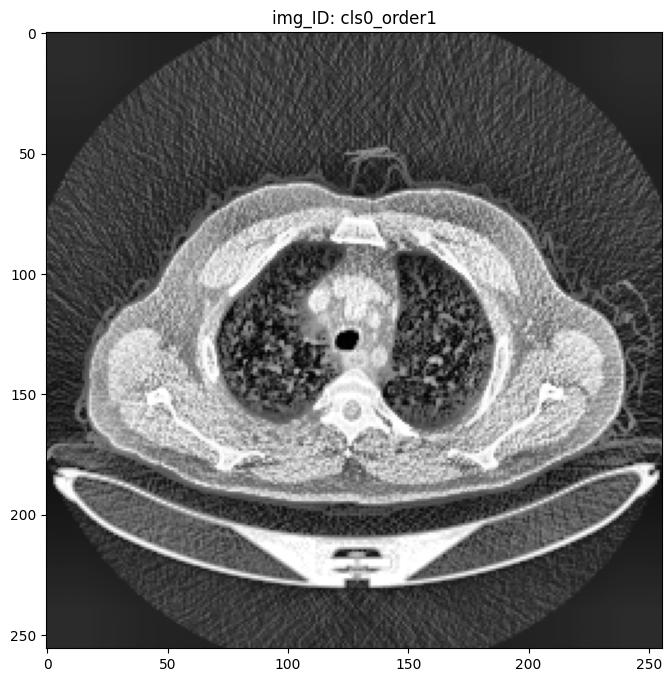

In [11]:
# load a image 
img_ID = "cls0_order1"

c1 = pipe_meta["img_ID"] == img_ID
arr_img_path = Path(PureWindowsPath(pipe_meta[c1]["path_img_pipe"].item()))
arr_img = np.load(arr_img_path)

plt.figure(figsize=(8,8))
plt.imshow(arr_img, cmap='gray', 
           # vmin=0, vmax=255,
          )
plt.title(f"img_ID: {img_ID}")
plt.show()

In [12]:
arr_img_path

PosixPath('../../../data/pipe003/pipe003_imgs/Normal cases/pipe003_cls0_order1_.npy')

## Custom Pytorch Dataset

In [13]:
# Creating dataset class
from typing import Tuple, Dict, List


class customPytorchDatset(Dataset):
    
    def __init__(self, d_meta):
        self.d_meta = d_meta

    def __len__(self) -> int: 
        "Returns the total number of samples."
        return len(self.d_meta)

    def __getitem__(self, index):
        fpath = Path(PureWindowsPath(self.d_meta["path_img_pipe"][index]))
        arr_img = np.load(fpath)
        arr_img = np.expand_dims(arr_img, axis=0) #
        arr_img = torch.tensor(arr_img)

        y_true = self.d_meta["cls_id"][index]
        y_true = torch.tensor(y_true, dtype=torch.int64)
        
        img_id = self.d_meta["img_ID"][index]

        
        return arr_img, y_true, img_id
    

In [14]:
arr_img, y_true, img_id = next(iter(customPytorchDatset(d_meta = pipe_meta)))
arr_img, y_true, img_id 

(tensor([[[0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
          [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
          [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
          ...,
          [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
          [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
          [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725]]],
        dtype=torch.float64),
 tensor(0),
 'cls0_order1')

In [15]:
arr_img.shape

torch.Size([1, 256, 256])

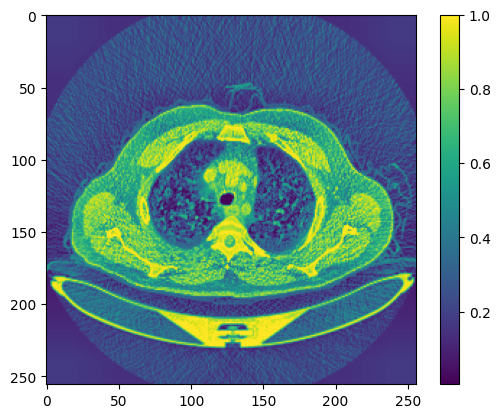

In [16]:
plt.imshow(arr_img.numpy()[0].squeeze())
plt.colorbar()
plt.show()

## Arch| RESNET_v1

In [17]:
class residual_block(nn.Module): 
    
    def __init__(self, 
                 in_channels, 
                 intermediate_channels, 
                 identity_downsample=None, 
                 stride=1,
                ):
            
        super(residual_block, self).__init__()
        
        self.expansion = 2
        
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=intermediate_channels, #64
                               kernel_size=3,
                               stride=stride,
                               padding=1,  #"same"
                               bias=True,
                              )
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(intermediate_channels)

        
        self.conv2 = nn.Conv2d(in_channels=intermediate_channels,
                               out_channels=intermediate_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1,  #"same"
                               bias=True,
                      )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)



        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)

        x = self.conv2(x)


        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
            
        x = x + identity
        
        x = self.relu(x)
        x = self.bn2(x) #<<<<<<
        return x


    
class ResNetv1(nn.Module):

    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNetv1, self).__init__()

        self.in_channels = 64
        
        self.bn0 = nn.BatchNorm2d(1)

        self.conv0 = nn.Conv2d(in_channels=image_channels, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, #"same"
                               bias=True)

        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # self.bn64 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(block=block, # Residual block
                                       num_residual_blocks=layers[0], 
                                       intermediate_channels=64, 
                                       stride=1)
        
        self.layer2 = self._make_layer(block=block, # Residual block
                                       num_residual_blocks=layers[1],
                                       intermediate_channels=128, # Expanding by 2 
                                       stride=2) # downsampling
        
        self.layer3 = self._make_layer(block=block, # Residual block
                                       num_residual_blocks=layers[2],
                                       intermediate_channels=256, # Expanding by 2 
                                       stride=2) # downsampling
        
        self.layer4 = self._make_layer(block=block, # Residual block
                                       num_residual_blocks=layers[3],
                                       intermediate_channels=256*2,
                                       stride=2) # downsampling
        

        self.avgpool2d = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.fc = nn.Sequential(nn.BatchNorm1d( 512 ),
                                nn.Linear(in_features= 512 , out_features=256),
                                nn.ReLU(),
                                nn.Linear(in_features=256, out_features=125),
                                nn.ReLU(),
                                nn.Linear(in_features=125, out_features=num_classes),
                               )
        

    def forward(self, x):

        x = self.bn0(x)
        x = self.conv0(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        
        x = self.layer2(x)
        
        x = self.layer3(x)
        
        x = self.layer4(x)

        x = self.avgpool2d(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return x
        # return F.softmax(x, dim=1) # I am using CrossEntropyLoss
        # return torch.sigmoid(x)


    
    
    
#========================================================
    def _make_layer(self, 
                    block,
                    num_residual_blocks, 
                    intermediate_channels, 
                    stride):
        identity_downsample = None
        layers = []

        #_____________________________________________________________
        # Adding Identity layer with downsampling if stride == 2
        if stride != 1:
            identity_downsample = nn.Conv2d(in_channels= self.in_channels,
                                            out_channels=intermediate_channels, # Expanding channels by 2 
                                            kernel_size=1,
                                            stride=stride, # downsampling with stride = 2
                                            bias=True,
                                           )
                                               
            layers.append(block(in_channels=self.in_channels,
                                intermediate_channels=intermediate_channels, 
                                identity_downsample=identity_downsample,
                                stride=stride)
                         )

            self.in_channels = intermediate_channels

        
        for i in range(num_residual_blocks - (1 if stride != 1 else 0)):

            layers.append(block(in_channels=self.in_channels,
                                intermediate_channels=intermediate_channels, 
                                identity_downsample=None,
                                stride=1)
                         )


        return nn.Sequential(*layers)

    
        

In [18]:
#_______________________________________
# Generating random input with expected shape 
x = torch.randn(2, 1, 256, 256) # Prototyping (Batch, img_chns, highxwidht)
# x = torch.randn(2, 1, 100, 100) # Prototyping (Batch, img_chns, highxwidht)
print(f"input shape (batch, img_chns, hight, width):\n{x.shape}\n\n")

#_______________________________________
# Model 
print(f"Model initializations...")
net = ResNetv1(block=residual_block,
             layers=[2, 2, 2, 2],
             image_channels=1,
             num_classes=3)

#_______________________________________
# Feed foward
out = net(x)

print(f"raw logists output")
out


input shape (batch, img_chns, hight, width):
torch.Size([2, 1, 256, 256])


Model initializations...
raw logists output


tensor([[-0.0836, -0.0470,  0.2299],
        [-0.1995, -0.1214, -0.0636]], grad_fn=<AddmmBackward0>)

### Arch VIZ

In [19]:
# ================================================
# Viz using torchview - GRAPH
model_graph = draw_graph(model=net, 
                         input_size=(1, 1,256,256), 
                         device='meta')

model_graph.resize_graph(scale=5.0) # Reduce image size

#-----
# Save graph image 
store_arch_graph_img = os.path.join(".","_graph_viz")
os.makedirs(store_arch_graph_img, exist_ok=True)

graph_img_name = f"{cfg.THIS_NOTEBOOK_REF}_graph_ResNetv1"
fpath = os.path.join(store_arch_graph_img, graph_img_name)

model_graph.visual_graph.render(fpath,
                                format="png",
                                 cleanup=True, # dont create .dot file
                               )

'_graph_viz/FR_t01e01nb04v2_graph_ResNetv1.png'

In [20]:
del net

## Training

### Training configuration

In [21]:
Training_trackID = f"TrainTrack_035" #"TrainTrack_" + "ID"  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< CAREFUL with OVERWRITE

pipe_params = {'prepro_pipe': {'pipe_name':'pipe003',
                               'source_code': 'FR_t02e01nb02v3',
                              }, 
               'architecture':{'arch_ID':'RESNET_v1',
                               'params': {'block':'nnModule_ResidualBlock', 
                                          'layers':[2,2,2,2], 
                                          'image_channels':1, 
                                          'num_classes':3,
                                         },
                               'source_code': cfg.THIS_NOTEBOOK_REF
                              },
               'split_strategy': {'split_strategy_id':'splt_strategy_004', # each one parameter change, id changes.
                                  'cv': 'custom_StratifiedKFold()',
                                  'n_split':5,
                                  'cls_col':"cls_id",
                                  'inst_n_order_col':"img_n_order",
                                  'shuffle_instances':False,
                                  'seed':[0,100],
                                  'comment': 'seed [start:end]: Repeated_KfoldCV | shuffle_instances=True generates leakage',
                                 },
               'training_step': {'TrackID': Training_trackID,
                                 'training_strategy_id':'trn_strategy_003', # each one parameter change, id changes.
                                 'source_code':cfg.THIS_NOTEBOOK_REF,
                                 'batch_size':300,
                                 'epochs':50,
                                 'lr':0.0001,
                                 'loss_fn':'CrossEntropyLoss',
                                 'balance_strategy': "class weight in loss_fn",
                                 'optimizer': 'Adam',
                                 'verbose_epo_steps':20,
                                 'save_model':False,
                                },
               "general_comments": "Arch similar to RESNET18", 
              }
#==============================================================================
to_save_root = cfg.ROOT_TO_SAVE_RESLT
track_train_id = pipe_params['training_step']['TrackID']

#----------------------------------------------------------
# creating folder to store ML pipeline params
root_perfom_across_epo = os.path.join(to_save_root,
                                      track_train_id,
                                      'ML_pipe_params',)
os.makedirs(root_perfom_across_epo, exist_ok=True)

#----------------------------------------------------------
# Saving ML pipeline params
pickle_fname = f"ML_pipe_all_params_{Training_trackID}.pkl"
fpath = os.path.join(root_perfom_across_epo, pickle_fname)
with open(fpath, 'wb') as fp:
    pickle.dump(pipe_params, fp)


### Stratify KFold 

In [22]:
# validation_imgID_folds = custom_StratifiedKFold(d_meta=pipe_meta,
#                                                 n_splits=pipe_params['split_strategy']['n_split'],
#                                                 cls_col=pipe_params['split_strategy']['cls_col'],
#                                                 inst_n_order_col=pipe_params['split_strategy']['inst_n_order_col'],
#                                                 shuffle_instances=pipe_params['split_strategy']['shuffle_instances'],
#                                                 random_state=pipe_params['split_strategy']['seed'],
#                                                )
# #====================================
# print(f"Check number of images per fold:")
# for f in validation_imgID_folds:
#     print(f"  Count of unique IDs per folds : {np.unique(f).shape} | {f.shape} ")
# print(f" Total of img_ids: {np.hstack(validation_imgID_folds).shape}")

### Training steps 

In [23]:
%%time

block          = residual_block if pipe_params['architecture']['params']['block'] == 'nnModule_ResidualBlock' else "false"
layers         = pipe_params['architecture']['params']['layers']
image_channels = pipe_params['architecture']['params']['image_channels']
num_classes    = pipe_params['architecture']['params']['num_classes']
arch_id        = pipe_params['architecture']['arch_ID']

first_seed     = pipe_params['split_strategy']['seed'][0]
second_seed    = pipe_params['split_strategy']['seed'][1]

epochs         = pipe_params['training_step']['epochs']
batch_size     = pipe_params['training_step']['batch_size']
lr             = pipe_params['training_step']['lr']
track_train_id = pipe_params['training_step']['TrackID']
save_model     = pipe_params['training_step']['save_model']
verbose        = pipe_params['training_step']['verbose_epo_steps']


for seed in range(first_seed,second_seed):

    print(f"_____________________________\nTraining for seed: {seed}")
    
    validation_imgID_folds = custom_StratifiedKFold(d_meta=pipe_meta,
                                                    n_splits=pipe_params['split_strategy']['n_split'],
                                                    cls_col=pipe_params['split_strategy']['cls_col'],
                                                    inst_n_order_col=pipe_params['split_strategy']['inst_n_order_col'],
                                                    shuffle_instances=pipe_params['split_strategy']['shuffle_instances'],
                                                    random_state=seed,
                                                   )

    for fold_n, imgIDs_fold in enumerate(validation_imgID_folds):
    
        foldID = f"seed{seed}_fold{fold_n}"
        
        #_________________________________________________________________
        # Split train and test dataset.
        c_tst = pipe_meta["img_ID"].isin(imgIDs_fold)
        d_tst = pipe_meta[c_tst].reset_index(drop=True)
        
        d_trn = pipe_meta[~c_tst].reset_index(drop=True)
        
        #_________________________________________________________________
        # Extracting weights for each class 
        class_counts = d_trn["cls_id"].value_counts().sort_index()
        N = class_counts.sum()
        K = len(class_counts)
        weights_ = N / (K * class_counts)
        weights = weights_.to_dict()
        
        #_________________________________________________________________
        # Custom pytorch dataset    
        trn_dataset = customPytorchDatset(d_meta = d_trn)
        tst_dataset = customPytorchDatset(d_meta = d_tst)
        
        #..................................................
        # Custom pytorch dataloader
        trn_loader = DataLoader(dataset=trn_dataset,
                                batch_size=batch_size,
                                shuffle=True,)
    
        tst_loader = DataLoader(dataset=tst_dataset,
                                batch_size=batch_size,
                                shuffle=False,)
        
        #_________________________________________________________________
        model = []
        model = ResNetv1(block=block,
                         layers=layers,
                         image_channels=image_channels,
                         num_classes=num_classes).to(device)
        
        #_________________________________________________________________
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        #_________________________________________________________________
        print(f"__________________\nTraining foldID: {foldID}")
        trn_rslts, tst_rslts = train(model=model,
                                     trn_loader=trn_loader,
                                     tst_loader=tst_loader,
                                     optimizer=optimizer,
                                     weights=weights,
                                     epochs=epochs,
                                     arch_id=arch_id,
                                     foldID=foldID,
                                     track_train_id=track_train_id,
                                     to_save_root=cfg.ROOT_TO_SAVE_RESLT,
                                     verbose_epo_steps=verbose,
                                     save_model=save_model
                                    )
        #_________________________________________________________________
        # Free memory
        model.cpu()
        del model, 
        del trn_dataset, tst_dataset
        del trn_loader, tst_loader
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
    
        #_________________________________________________________________
        # break

    

_____________________________
Training for seed: 0
__________________
Training foldID: seed0_fold0
Epo: 0 | tr_loss: 0.9835 | tr_acc: 0.6655 | tst_loss: 0.8247 | tst_acc: 0.8054 |tst_ba: 0.4919 |tst_f1: 0.6646 |tst_pr: 0.7410 |tst_rc: 0.6612 |lr: 0.000100 |
Epo: 20 | tr_loss: 0.0058 | tr_acc: 1.0000 | tst_loss: 0.6920 | tst_acc: 0.7602 |tst_ba: 0.4384 |tst_f1: 0.6217 |tst_pr: 0.6393 |tst_rc: 0.6256 |lr: 0.000100 |
Epo: 40 | tr_loss: 0.0019 | tr_acc: 1.0000 | tst_loss: 0.7920 | tst_acc: 0.7647 |tst_ba: 0.4593 |tst_f1: 0.6363 |tst_pr: 0.6536 |tst_rc: 0.6395 |lr: 0.000100 |
Epo: 49 | tr_loss: 0.0012 | tr_acc: 1.0000 | tst_loss: 0.8149 | tst_acc: 0.7647 |tst_ba: 0.4593 |tst_f1: 0.6363 |tst_pr: 0.6536 |tst_rc: 0.6395 |lr: 0.000100 |
__________________
Training foldID: seed0_fold1
Epo: 0 | tr_loss: 1.0130 | tr_acc: 0.5114 | tst_loss: 0.8257 | tst_acc: 0.6256 |tst_ba: 0.4943 |tst_f1: 0.4794 |tst_pr: 0.6692 |tst_rc: 0.6629 |lr: 0.000100 |
Epo: 20 | tr_loss: 0.0076 | tr_acc: 1.0000 | tst_loss: 

KeyboardInterrupt: 

In [ ]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(f"{name}: {param.grad.norm()}")

In [ ]:
# for batch, (arr_img, y_true, img_id) in enumerate(trn_loader):
#     break
    

In [ ]:
# plt.imshow(arr_img.numpy().squeeze()[3])